In [1]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
#os.chdir('data')
from colorsetup import colors, palette
sns.set_palette(palette)
import warnings
warnings.simplefilter(action='ignore')
import fbprophet
import pmdarima as pm

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
covid = pd.read_csv('./COVID-19 di Indonesia @kawalcovid19 - Statistik Harian.csv')
covid.head()

,Unnamed: 0,Kasus harian,Kasus Impor,Kasus Lokal,Total kasus,Kasus aktif,% kasus aktif,Sembuh\n(baru),Sembuh,Tingkat kesembuhan (seluruh kasus),...,Positif DKI,Unnamed: 76,Pos Rate DKI,Pos Rate DKI - 7 harian,NON DKI,Positif Non DKI,Unnamed: 81,Pos Rate Non DKI,Pos Rate Non DKI - 7 harian,CFR
0,3/2/2020,2,0.0,2.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3/3/2020,0,0.0,0.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/4/2020,0,0.0,0.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3/5/2020,0,0.0,0.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3/6/2020,2,0.0,2.0,4,4,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
covid.columns


Index(['Unnamed: 0', 'Kasus harian', 'Kasus Impor', 'Kasus Lokal',
       'Total kasus', 'Kasus aktif', '% kasus aktif', 'Sembuh\n(baru)',
       'Sembuh', 'Tingkat kesembuhan (seluruh kasus)',
       'Tingkat kesembuhan (closed cases)', 'Meninggal\n(baru)',
       'Meninggal\nDunia', 'Tingkat kematian (seluruh kasus)',
       'Tingkat kematian (closed cases)', 'PDP', 'ODP', 'Suspek aktif',
       'Jumlah spesimen diperiksa (dari 1 April)', 'Jumlah orang diperiksa',
       'Negatif', 'Positif \n(=C)', 'Dalam Proses', 'Spesimen',
       'Spesimen (PCR-TCM)', 'Spesimen (Antigen)', 'Orang yang dites',
       'Orang yang dites (PCR-TCM)', 'Orang yang dites (Antigen)',
       'Vaksinasi (ineligible)', 'Jumlah test/juta penduduk', 'Test/Positif',
       'Jumlah org yg dites / positif', 'Jumlah Test/Positif harian',
       'Positif / Jumlah Tes', 'Positive rate harian', 'Case Growth Rate',
       'Tingkat positivitas mingguan',
       'Jumlah spesimen diperiksa (rata-rata 7 hari)',
       'Ju

In [5]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 85 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         583 non-null    object 
 1   Kasus harian                                       582 non-null    object 
 2   Kasus Impor                                        10 non-null     float64
 3   Kasus Lokal                                        10 non-null     float64
 4   Total kasus                                        582 non-null    object 
 5   Kasus aktif                                        582 non-null    object 
 6   % kasus aktif                                      582 non-null    object 
 7   Sembuh
(baru)                                      582 non-null    object 
 8   Sembuh                                             582 non-null    object 
 9   Tingkat ke

In [6]:
columns_ = ['Kasus aktif']
df=covid[columns_]
df.dropna(inplace=True)

In [7]:
df

,Kasus aktif
0,2
1,2
2,2
3,2
4,4
...,...
577,"34,867"
578,"33,812"
579,"32,876"
580,"31,054"


## Data Wrangling

In [39]:
index = pd.date_range('3/3/2020', periods=582, freq='D') #create new index with assigning timedate on it
df.index = index
df

,Kasus aktif
2020-03-03,2
2020-03-04,2
2020-03-05,2
2020-03-06,2
2020-03-07,4
...,...
2021-10-01,"34,867"
2021-10-02,"33,812"
2021-10-03,"32,876"
2021-10-04,"31,054"


In [40]:
#df['Date'] = df.index

In [41]:
a = df[df.index>='3/12/2020'] #drop the early date as there are missing data
a

,Kasus aktif
2020-03-12,27
2020-03-13,60
2020-03-14,83
2020-03-15,104
2020-03-16,121
...,...
2021-10-01,"34,867"
2021-10-02,"33,812"
2021-10-03,"32,876"
2021-10-04,"31,054"


In [42]:
df_ = a.copy()
df1 = df_.copy()
df1

,Kasus aktif
2020-03-12,27
2020-03-13,60
2020-03-14,83
2020-03-15,104
2020-03-16,121
...,...
2021-10-01,"34,867"
2021-10-02,"33,812"
2021-10-03,"32,876"
2021-10-04,"31,054"


In [43]:
df1.dtypes

Kasus aktif    object
dtype: object

In [44]:
df1['Kasus aktif'] = df1['Kasus aktif'].replace(',','', regex=True) #remove comma 
df1['Kasus aktif'] = df1['Kasus aktif'].apply(pd.to_numeric,errors='coerce') #change object into numeric
df1.dtypes

Kasus aktif    int64
dtype: object

In [45]:
#Check data accountability

#1. Data Duplicate
print('Number of duplicated data: ', df1.duplicated().sum())

#2. Missing Data
print('Number of missing (NaN/null) data: ', df1.isnull().sum())

#3. Number of date range
print('Discrepancy of actual date range with dataset: ', len(df1) - len(df1.index.unique()))

Number of duplicated data:  1
Number of missing (NaN/null) data:  Kasus aktif    0
dtype: int64
Discrepancy of actual date range with dataset:  0


In [46]:
df1[df1.duplicated()]

,Kasus aktif
2020-11-02,55792


In [47]:
df1[df1.index>='11/1/2020']
#seeing no strange duplicated data, we move on

,Kasus aktif
2020-11-01,56899
2020-11-02,55792
2020-11-03,54732
2020-11-04,54190
2020-11-05,54306
...,...
2021-10-01,34867
2021-10-02,33812
2021-10-03,32876
2021-10-04,31054


## EDA

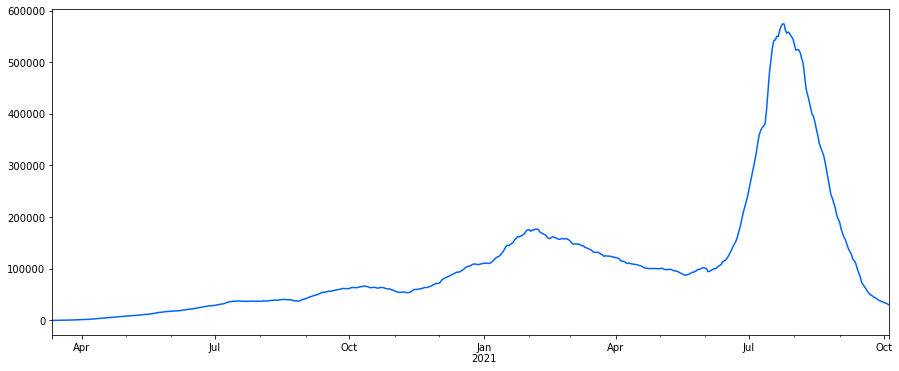

In [48]:
#Plot the sequence data 

df1['Kasus aktif'].plot(figsize=(15, 6))

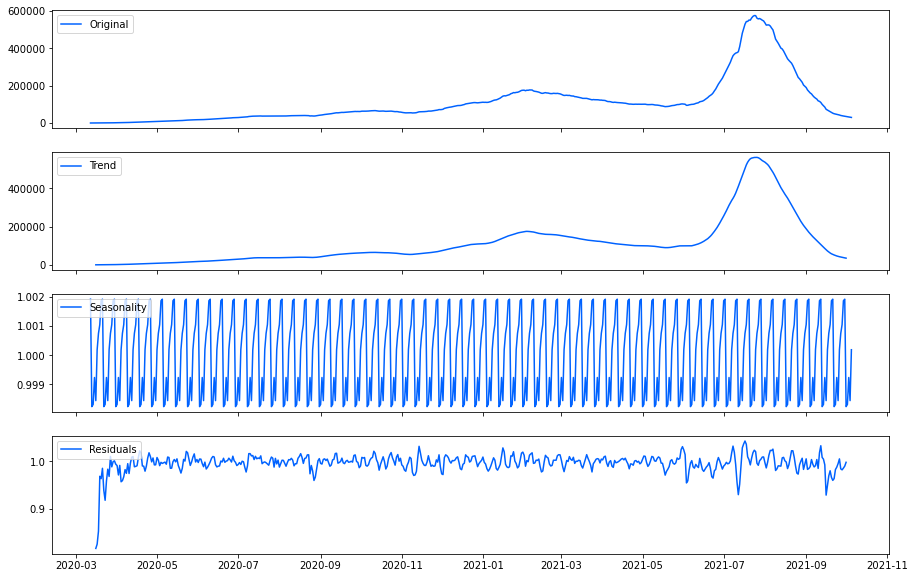

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=df1, model='mul', period=9)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

fig, axes = plt.subplots(4,1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df1, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [50]:
# resample to annual and plot each
monthly_cases = df1.resample('M').mean()
#monthly_cases.plot(figsize=[14,4])
monthly_cases

,Kasus aktif
2020-03-31,514.500000
2020-04-30,4426.200000
2020-05-31,12435.516129
2020-06-30,22786.866667
2020-07-31,35358.129032
2020-08-31,38906.580645
2020-09-30,54175.833333
2020-10-31,63221.806452
2020-11-30,60277.233333
2020-12-31,95449.580645


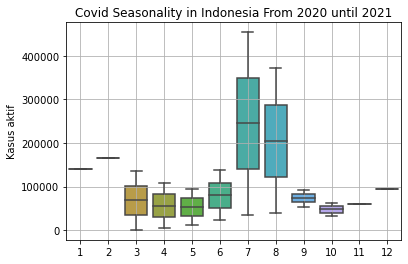

In [51]:
# boxplot of mean cases of months to determine variance and range
sns.boxplot(x=monthly_cases.index.month, y=monthly_cases['Kasus aktif'])
plt.title('Covid Seasonality in Indonesia From 2020 until 2021')
plt.grid(b=True); #GRID is to create rectangular block format


We can see there's seasonality within 2 years, whereas July and August is the worst month throughout years. 

## Stationary or Not Stationary?

In [52]:
#Let's run the ADF test before transforming.
from statsmodels.tsa.stattools import adfuller, kpss
#Now we'll be doing statistical test for trend seasonality using KPSS.
#Null hypothesis for KPSS is opposite from ADF. If ADF null hypothesis is non-stationary, the KPSS null hypothesis is stationary. 


In [53]:

# ADF Test
result = adfuller(df1['Kasus aktif'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# KPSS Test
result = kpss(df1['Kasus aktif'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.189539330144429
p-value: 0.020598224784470924
Critial Values:
   1%, -3.4421447800270673
Critial Values:
   5%, -2.8667429272780858
Critial Values:
   10%, -2.5695409929766093

KPSS Statistic: 1.405611
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [54]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           -3.189539
p-value                   0.020598
Lags Used                15.000000
Observations Used       557.000000
Critical Value (1%)      -3.442145
Critical Value (5%)      -2.866743
Critical Value (10%)     -2.569541
dtype: float64


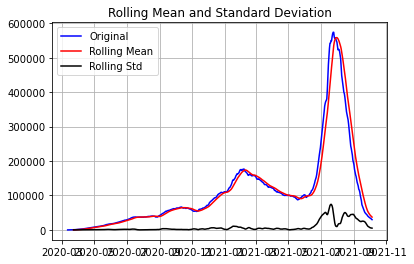

In [55]:
# run DFT on monthly
dftest(df1['Kasus aktif'])

# p-value fails to reject null hypothesis of non-stationary , thus data is non-stationary


From pvalue and rolling mean & variance, we can say this series is Non Stationary (weak seasonality)

# ARIMA Model

## Stationary Transformation using Differencing

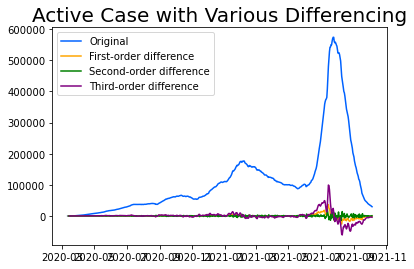

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Try various differencing order
df1['Diff1'] = df1['Kasus aktif'].diff()
df1['Diff2'] = df1['Kasus aktif'].diff().diff()
df1['Diff3'] = df1['Kasus aktif'].diff(periods=3)

#case = case.dropna()

# Plot
plt.title('Active Case with Various Differencing', size=20)
plt.plot(df1['Kasus aktif'], label='Original')
plt.plot(df1['Diff1'], label='First-order difference', color='orange')

plt.plot(df1['Diff2'], label='Second-order difference', color='green')

plt.plot(df1['Diff3'], label='Third-order difference', color='purple')


plt.legend();

Test Statistic         -6.271908e+00
p-value                 3.985314e-08
Lags Used               1.300000e+01
Observations Used       5.570000e+02
Critical Value (1%)    -3.442145e+00
Critical Value (5%)    -2.866743e+00
Critical Value (10%)   -2.569541e+00
dtype: float64


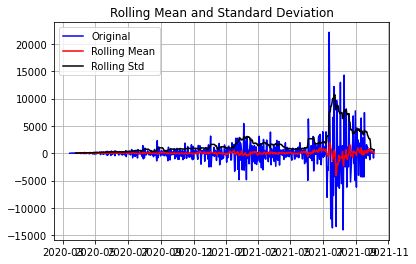

In [57]:
dftest(df1['Diff2'].dropna())

In [58]:
#choose d=2 since the series is now stationary

In [59]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

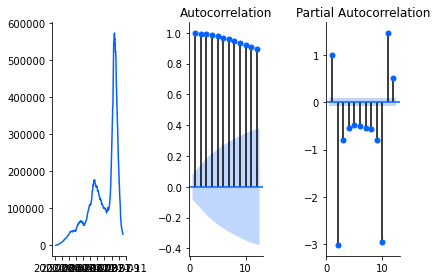

In [60]:

plots(df1['Kasus aktif'], lags=12);


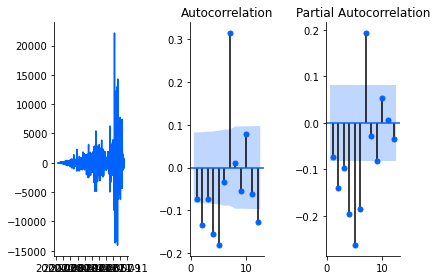

In [61]:
plots(df1['Kasus aktif'].diff().diff().dropna(), lags=12);
# open Duke guide for visual

#we see if diff=2, the ACF directly went below 0 which indicates over-differencing, so we go tentatively with d= diff=1

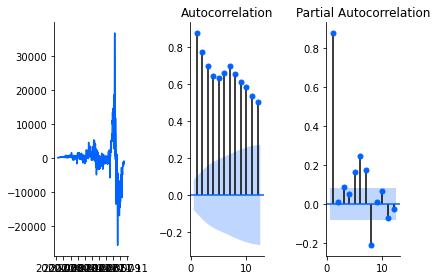

In [62]:
plots(df1['Kasus aktif'].diff().dropna(), lags=12);
# p order indicates PACF we go for p=1
# q is order indicates ACF. Couple lags shown, but we go tentatively with q=2. when in doubt choose the simpler one. 

In [37]:
#now lets check its statistical ARIMA Model Result 

from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df1['Kasus aktif'], order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

#we see at the middle of table. 
#Seems for MA order we choose the right order since P>|z| should ideally be less than 0.05 for the respective X to be significant.

                             ARIMA Model Results                              
Dep. Variable:          D.Kasus aktif   No. Observations:                  572
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5274.837
Method:                       css-mle   S.D. of innovations           2444.105
Date:                Sat, 09 Oct 2021   AIC                          10559.674
Time:                        12:42:43   BIC                          10581.420
Sample:                    03-13-2020   HQIC                         10568.157
                         - 10-05-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  52.0909   1161.878      0.045      0.964   -2225.149    2329.331
ar.L1.D.Kasus aktif     0.9470      0.020     47.431      0.000       0.908       0.986
ma.L1.D.Kasus ak

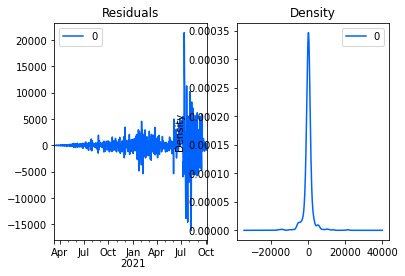

In [189]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [190]:
#now lets check its statistical ARIMA Model Result 

from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df1['Kasus aktif'], order=(3,0,2)) #based on AutoARIMA
model_fitA = model.fit(disp=0)
print(model_fit.summary())

#we see at the middle of table. 
#Seems for MA order we choose the right order since P>|z| should ideally be less than 0.05 for the respective X to be significant.

                             ARIMA Model Results                              
Dep. Variable:          D.Kasus aktif   No. Observations:                  572
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5274.837
Method:                       css-mle   S.D. of innovations           2444.105
Date:                Sat, 09 Oct 2021   AIC                          10559.674
Time:                        08:05:34   BIC                          10581.420
Sample:                    03-13-2020   HQIC                         10568.157
                         - 10-05-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  52.0909   1161.878      0.045      0.964   -2225.149    2329.331
ar.L1.D.Kasus aktif     0.9470      0.020     47.431      0.000       0.908       0.986
ma.L1.D.Kasus ak

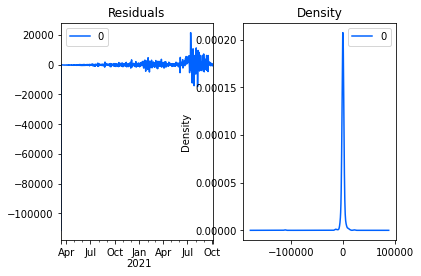

In [191]:
# Plot residual errors
residuals = pd.DataFrame(model_fitA.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
#The residual errors in uniform variance. Let’s plot the actuals against the fitted values using plot_predict().

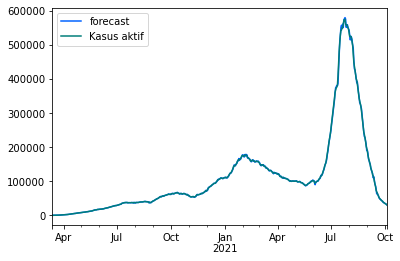

In [194]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

#When you set dynamic=False the in-sample lagged values are used for prediction.
#That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.



In [74]:
#Cross Validation

from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df1['Kasus aktif'][:487]
test = df1['Kasus aktif'][487:]

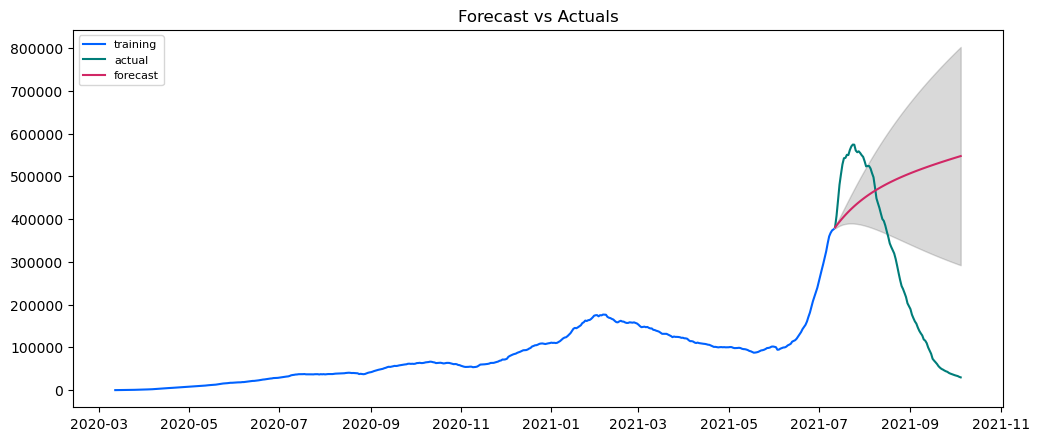

In [195]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 2))  #Based on sight order
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(86, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [196]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 3.43914467928973,
 'me': 194532.6972081,
 'mae': 255775.00795286166,
 'mpe': 3.325613589954135,
 'rmse': 307827.63472551445,
 'acf1': 0.9842422602338865,
 'corr': -0.9078706449408397,
 'minmax': 0.48802830682705045}

In [38]:
model = pm.auto_arima(df1['Kasus aktif'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15398.095, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=14978.862, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10981.011, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10592.071, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10592.379, Time=0.58 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10580.686, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10805.801, Time=0.74 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=10568.060, Time=0.42 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=10570.067, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=10563.179, Time=0.96 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10579.093, Time=0.41 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   :

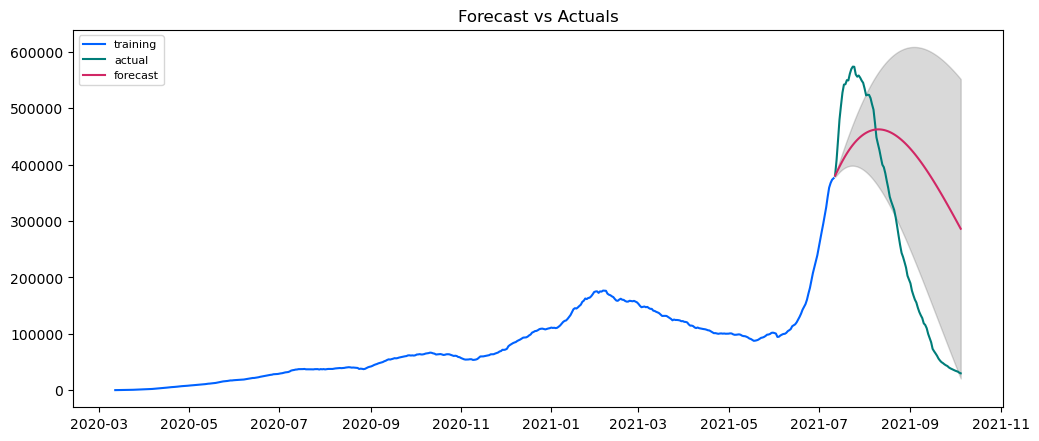

In [204]:
# Build Model  
model = ARIMA(train, order=(3, 0, 2))  #Based on AutoArima
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(86, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [210]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 2.08101011070349,
 'me': 118945.73878323747,
 'mae': 177289.04767888354,
 'mpe': 1.972763566274813,
 'rmse': 201468.96242400227,
 'acf1': 0.9908119584739211,
 'corr': 0.7382151109865693,
 'minmax': 0.4493902725910468}

This is why AutoArima can complement of choosing order of p,d,q through ACF-PACF sight.

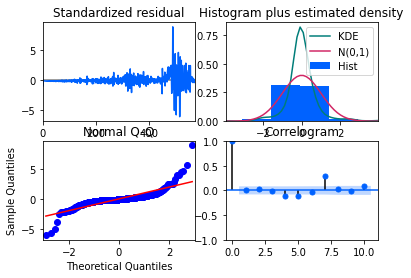

In [209]:
model.plot_diagnostics();

So how to interpret the plot diagnostics?

Top left: The residual errors seem to fluctuate around a mean of zero.

Top Right: The density plot suggest normal distribution with mean zero.


Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model

From result Now let us predict for next 6 months

In [206]:
#create dataframe that allow prediction 
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_months):
    pred_first = series.index.max()+relativedelta(months=0)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

In [207]:
preds = future_preds_df(model,df1['Kasus aktif'],6)
preds.tail() #model should directly come from AutoArima

,0
2021-12-01,28095.175437
2022-01-01,27446.218778
2022-02-01,26926.867101
2022-03-01,26531.693099
2022-04-01,26256.594071


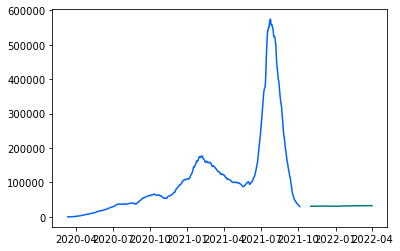

In [292]:
plt.plot(df1['Kasus aktif'])
plt.plot(preds)

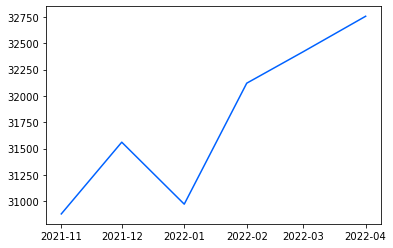

In [293]:
plt.plot(preds)